# wRMSD calculation

This notebook analyzes the results of molecular dynamics simulations of antibody molecules.
It calculates the root-mean-square deviation (RMSD) between the candidate antibody and the reference antibody,
and uses this to calculate the weighted RMSD (wRMSD) based on the accessibility and movability of each residue.

The notebook requires the MDAnalysis library to be installed.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import MDAnalysis as mda

In [2]:
# Define paths to the reference and candidates antibody simulation data
PATH_REFERENCE = 'md_simulations/remicade_humanization/remicade/'
PATH_CANDIDATE_Aa = 'md_simulations/remicade_humanization/candidate_Aa/'
PATH_CANDIDATE_Cb = 'md_simulations/remicade_humanization/candidate_Cb/'
PATH_REMICADE_2 = 'md_simulations/remicade_humanization/remicade_2/'

# Define the CDR residues for the antibodies
CDRS = {
    'H1': (26, 33),    # 26-32
    'H2': (52, 60),    # 52-59
    'H3': (101, 110),  # 101-109
    'L1': (144, 155),  # 24-34
    'L2': (170, 177),  # 50-56
    'L3': (209, 218),  # 89-97
}

N = sum([val[1] - val[0] for val in CDRS.values()])

In [3]:
# Load the reference and candidates antibody simulation data
# reference = mda.Universe(os.path.join(PATH_REFERENCE, 'structures/newbox.gro'),
#                          os.path.join(PATH_REFERENCE, 'prod_test/prod_test_noPBC_center.xtc')
#                         )
reference = mda.Universe(os.path.join(PATH_REFERENCE, 'structures/newbox.gro'),
                         os.path.join(PATH_REFERENCE, 'prod_10ns/prod_10ns_noPBC_center.xtc')
                        )
# candidate_Aa = mda.Universe(os.path.join(PATH_CANDIDATE_Aa, 'structures/newbox.gro'),
#                             os.path.join(PATH_CANDIDATE_Aa, 'prod_test/prod_test_noPBC_center.xtc')
#                            )
candidate_Aa = mda.Universe(os.path.join(PATH_CANDIDATE_Aa, 'structures/newbox.gro'),
                            os.path.join(PATH_CANDIDATE_Aa, 'prod_10ns/prod_10ns_noPBC_center.xtc')
                           )
# candidate_Cb = mda.Universe(os.path.join(PATH_CANDIDATE_Cb, 'structures/newbox.gro'),
#                             os.path.join(PATH_CANDIDATE_Cb, 'prod_test/prod_test_noPBC_center.xtc')
#                            )
candidate_Cb = mda.Universe(os.path.join(PATH_CANDIDATE_Cb, 'structures/newbox.gro'),
                            os.path.join(PATH_CANDIDATE_Cb, 'prod_10ns/prod_10ns_noPBC_center.xtc')
                           )
# remicade_2 = mda.Universe(os.path.join(PATH_REMICADE_2, 'structures/newbox.gro'),
#                           os.path.join(PATH_REMICADE_2, 'prod_test/prod_test_noPBC_center.xtc')
#                          )
remicade_2 = mda.Universe(os.path.join(PATH_REMICADE_2, 'structures/newbox.gro'),
                          os.path.join(PATH_REMICADE_2, 'prod_10ns/prod_10ns_noPBC_center.xtc')
                         )

reference, candidate_Aa, candidate_Cb, remicade_2

(<Universe with 3445 atoms>,
 <Universe with 3476 atoms>,
 <Universe with 3465 atoms>,
 <Universe with 3445 atoms>)

$$RMSD_i = \sqrt{\frac{\sum_j \left(d_{ij} - d_{ij}^0 \right)^2}{n}}$$

$$wRMSD = \sum_i w_{i-accessibility} w_{i-movability} RMSD_i$$

$$w_{i-accessibility} = \frac{SASA_i}{SASA_{i.avg}}$$

$$w_{i-movability} = 1 / \left(\frac{RMSF_i^0}{RMSF_{i.avg}^0} \right)$$

In [4]:
def read_xvg_file(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith(('#', '@')):
                continue
            
            data.append(line)

    return np.loadtxt(data)


# Define a function to calculate the distance matrix from a set of coordinates
def coordinates2distance_matrix(coordinates):
    return np.sqrt(np.sum((coordinates[:, np.newaxis, :] - coordinates[np.newaxis, :, :]) ** 2, axis=-1))


def compute_wrmsd(candidate, reference, sasa, rmsf):
    reference_cdr = sum([reference.residues[val[0] - 1:val[1] - 1].atoms for val in CDRS.values()])
    reference_cdr_ca = reference_cdr.select_atoms('name CA')

    candidate_cdr = sum([candidate.residues[val[0] - 1:val[1] - 1].atoms for val in CDRS.values()])
    candidate_cdr_ca = candidate_cdr.select_atoms('name CA')
    
    rmsd = []
    # Calculate the RMSD for each frame of the trajectories
    for ts_ref, ts_cand in tqdm(zip(reference.trajectory, candidate.trajectory)):
        distance_matrix_ref = coordinates2distance_matrix(ts_ref[reference_cdr_ca.ix])
        distance_matrix_cand = coordinates2distance_matrix(ts_cand[candidate_cdr_ca.ix])
        rmsd.append(np.sqrt(np.sum((distance_matrix_cand - distance_matrix_ref) ** 2, axis=1) / (N - 1)))
    
    rmsd = np.array(rmsd)
    accessibility_weights = sasa / sasa.sum(axis=1).reshape(-1, 1)
    
    rmsf_cdr = np.hstack([rmsf[val[0] - 1:val[1] - 1] for val in CDRS.values()])
    movability_weights = rmsf_cdr.mean() / rmsf_cdr
    
    return np.sum(rmsd * accessibility_weights * movability_weights, axis=1)


def smooth_array(arr, window_size: int=1000):
    smoothing_kernel = np.ones(window_size) / window_size
    return np.convolve(np.pad(arr, (window_size // 2, (window_size - 1) // 2), 'reflect'), 
                       smoothing_kernel, mode='valid')

def plot_wrmsd(wrmsd, window_size: int=1000):
    plt.plot(wrmsd)
    plt.plot(smooth_array(wrmsd, window_size))
    plt.show()

In [5]:
sasa_reference = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/sasa_10ns.xvg'))[:, 2:]
sasa_reference_2 = read_xvg_file(os.path.join(PATH_REMICADE_2, 'analysis/sasa_10ns.xvg'))[:, 2:]

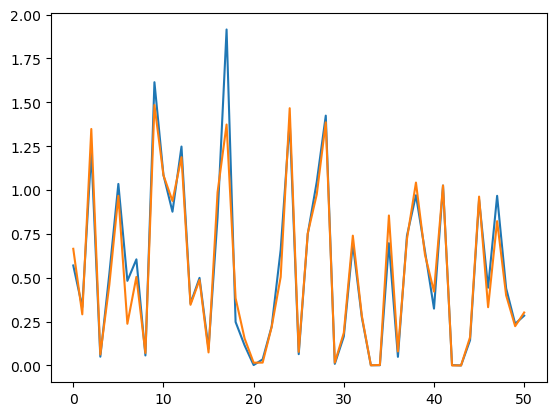

In [6]:
plt.plot(sasa_reference.mean(axis=0))
plt.plot(sasa_reference_2.mean(axis=0))
plt.show()

In [7]:
rmsf = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/rmsf_10ns.xvg'))[:, 1]
rmsf_2 = read_xvg_file(os.path.join(PATH_REMICADE_2, 'analysis/rmsf_10ns.xvg'))[:, 1]

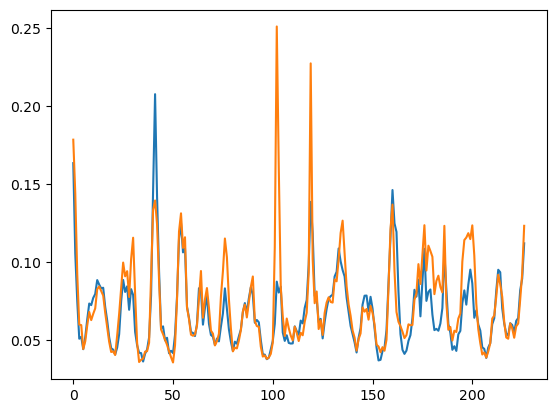

In [8]:
plt.plot(rmsf)
plt.plot(rmsf_2)
plt.show()

In [9]:
wrmsd_Aa = compute_wrmsd(candidate_Aa, reference, sasa_reference, rmsf)
wrmsd_Cb = compute_wrmsd(candidate_Cb, reference, sasa_reference, rmsf)
wrmsd_remicade = compute_wrmsd(remicade_2, reference, sasa_reference, rmsf)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

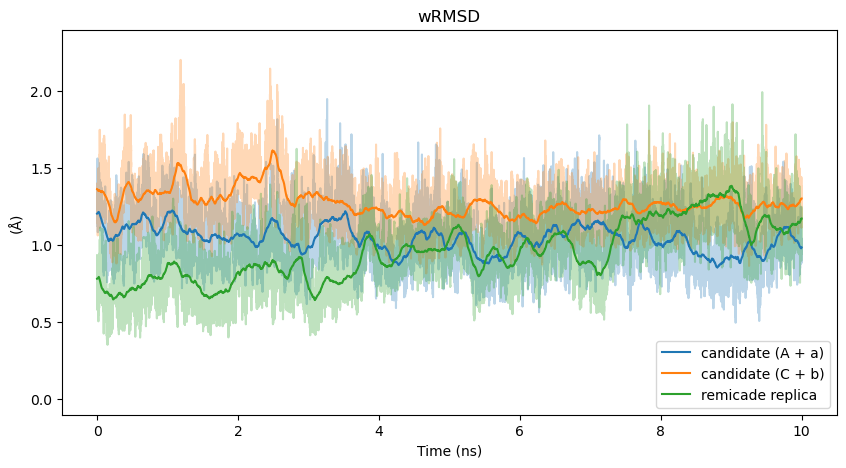

In [10]:
plt.figure(figsize=(10, 5))
plt.title('wRMSD')
plt.plot(np.linspace(0.0, 10.0, 50001), wrmsd_Aa, alpha=0.3)
plt.plot(np.linspace(0.0, 10.0, 50001), wrmsd_Cb, alpha=0.3)
plt.plot(np.linspace(0.0, 10.0, 50001), wrmsd_remicade, alpha=0.3)
plt.plot(np.linspace(0.0, 10.0, 50001), smooth_array(wrmsd_Aa), 'C0', label='candidate (A + a)')
plt.plot(np.linspace(0.0, 10.0, 50001), smooth_array(wrmsd_Cb), 'C1', label='candidate (C + b)')
plt.plot(np.linspace(0.0, 10.0, 50001), smooth_array(wrmsd_remicade), 'C2', label='remicade replica')
plt.legend()
plt.ylabel('(Å)')
plt.xlabel('Time (ns)')
plt.ylim(-0.1, 2.4)
# plt.savefig('presentation/wRMSD_plot.png')
plt.show()

In [11]:
print(f'Mean wRMSD for candidate (A + a): {wrmsd_Aa.mean():.3f}')
print(f'Mean wRMSD for candidate (C + b): {wrmsd_Cb.mean():.3f}')
print(f'Mean wRMSD for remicade replica : {wrmsd_remicade.mean():.3f}')

Mean wRMSD for candidate (A + a): 1.045
Mean wRMSD for candidate (C + b): 1.275
Mean wRMSD for remicade replica : 0.956


In [12]:
wrmsd_Aa = compute_wrmsd(candidate_Aa, remicade_2, sasa_reference_2, rmsf_2)
wrmsd_Cb = compute_wrmsd(candidate_Cb, remicade_2, sasa_reference_2, rmsf_2)
wrmsd_remicade = compute_wrmsd(reference, remicade_2, sasa_reference_2, rmsf_2)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

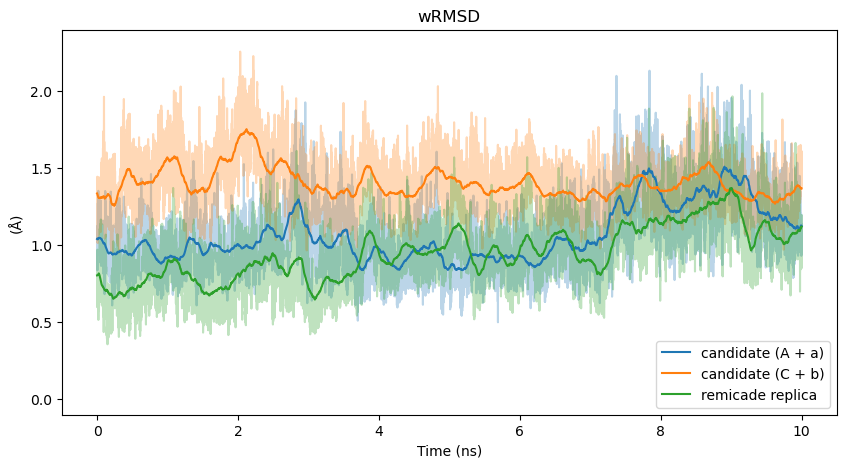

In [13]:
plt.figure(figsize=(10, 5))
plt.title('wRMSD')
plt.plot(np.linspace(0.0, 10.0, 50001), wrmsd_Aa, alpha=0.3)
plt.plot(np.linspace(0.0, 10.0, 50001), wrmsd_Cb, alpha=0.3)
plt.plot(np.linspace(0.0, 10.0, 50001), wrmsd_remicade, alpha=0.3)
plt.plot(np.linspace(0.0, 10.0, 50001), smooth_array(wrmsd_Aa), 'C0', label='candidate (A + a)')
plt.plot(np.linspace(0.0, 10.0, 50001), smooth_array(wrmsd_Cb), 'C1', label='candidate (C + b)')
plt.plot(np.linspace(0.0, 10.0, 50001), smooth_array(wrmsd_remicade), 'C2', label='remicade replica')
plt.legend()
plt.ylabel('(Å)')
plt.xlabel('Time (ns)')
plt.ylim(-0.1, 2.4)
# plt.savefig('presentation/wRMSD_plot.png')
plt.show()

In [14]:
print(f'Mean wRMSD for candidate (A + a): {wrmsd_Aa.mean():.3f}')
print(f'Mean wRMSD for candidate (C + b): {wrmsd_Cb.mean():.3f}')
print(f'Mean wRMSD for remicade replica : {wrmsd_remicade.mean():.3f}')

Mean wRMSD for candidate (A + a): 1.066
Mean wRMSD for candidate (C + b): 1.406
Mean wRMSD for remicade replica : 0.951


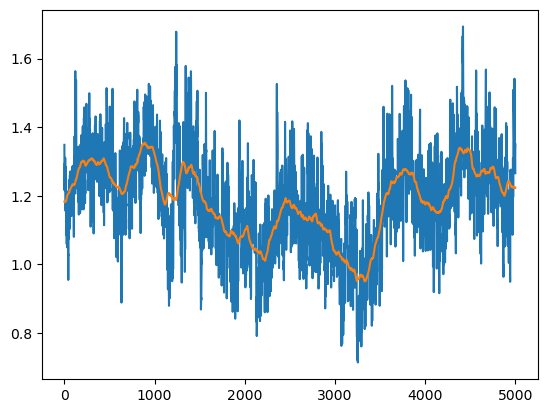

In [9]:
plot_wrmsd(wrmsd_Aa)

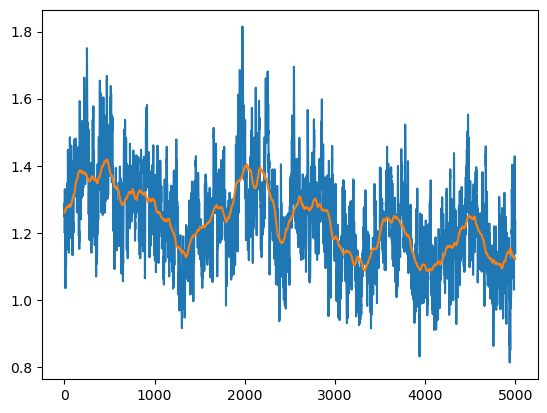

In [12]:
plot_wrmsd(wrmsd_Cb)

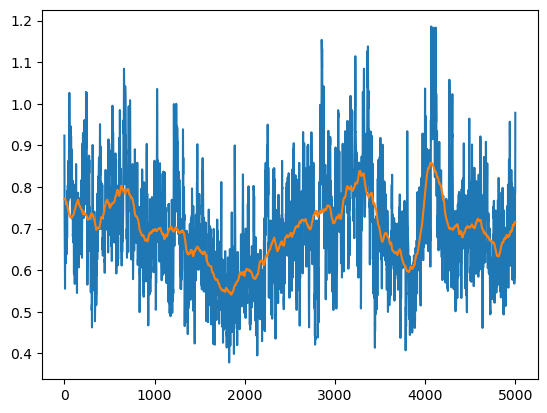

In [13]:
plot_wrmsd(wrmsd_remicade)

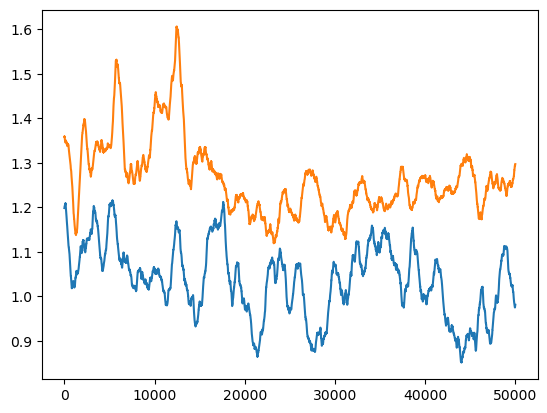

In [58]:
plt.plot(smooth_array(wrmsd_Aa))
plt.plot(smooth_array(wrmsd_Cb))
# plt.plot(smooth_array(wrmsd_remicade))
plt.show()

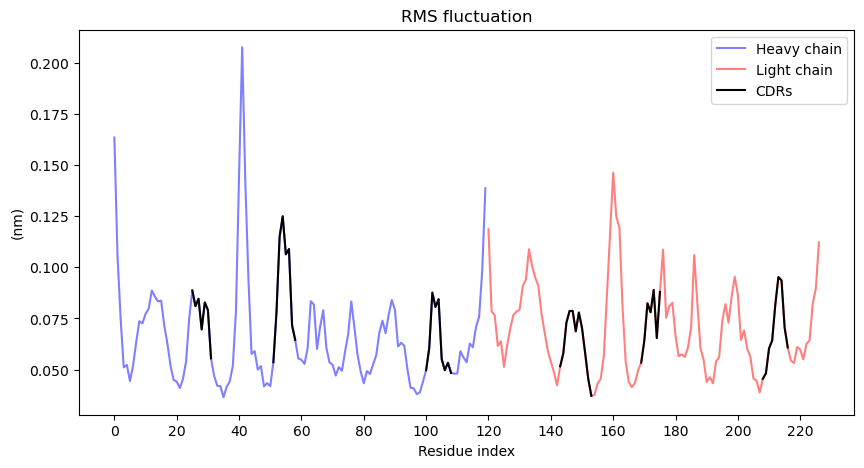

In [16]:
rmsf = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/rmsf_10ns.xvg'))[:, 1]

plt.figure(figsize=(10, 5))
plt.plot(np.arange(120), rmsf[:120], 'b', alpha=0.5, label='Heavy chain')
plt.plot(np.arange(120, 227), rmsf[120:], 'r', alpha=0.5, label='Light chain')
for val in CDRS.values():
    if val[0] == 26:
        plt.plot(np.arange(val[0] - 1, val[1] - 1), rmsf[val[0] - 1:val[1] - 1], 'k', label='CDRs')
    else:
        plt.plot(np.arange(val[0] - 1, val[1] - 1), rmsf[val[0] - 1:val[1] - 1], 'k')
plt.title('RMS fluctuation')
plt.xlabel('Residue index')
plt.ylabel('(nm)')
plt.xticks(np.arange(0, 227, 20))
plt.legend()
# plt.savefig('presentation/rmsf.png')
plt.show()

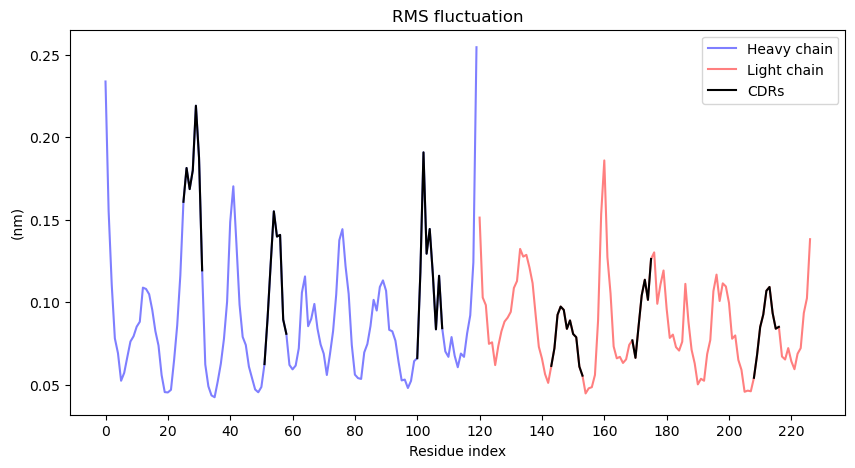

In [18]:
rmsf = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/rmsf_0_80.xvg'))[:, 1]

plt.figure(figsize=(10, 5))
plt.plot(np.arange(120), rmsf[:120], 'b', alpha=0.5, label='Heavy chain')
plt.plot(np.arange(120, 227), rmsf[120:], 'r', alpha=0.5, label='Light chain')
for val in CDRS.values():
    if val[0] == 26:
        plt.plot(np.arange(val[0] - 1, val[1] - 1), rmsf[val[0] - 1:val[1] - 1], 'k', label='CDRs')
    else:
        plt.plot(np.arange(val[0] - 1, val[1] - 1), rmsf[val[0] - 1:val[1] - 1], 'k')
plt.title('RMS fluctuation')
plt.xlabel('Residue index')
plt.ylabel('(nm)')
plt.xticks(np.arange(0, 227, 20))
plt.legend()
# plt.savefig('presentation/rmsf.png')
plt.show()

In [20]:
rmsf_10 = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/rmsf_10ns.xvg'))
rmsf_0_10 = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/rmsf_0_10.xvg'))
rmsf_0_80 = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/rmsf_0_80.xvg'))

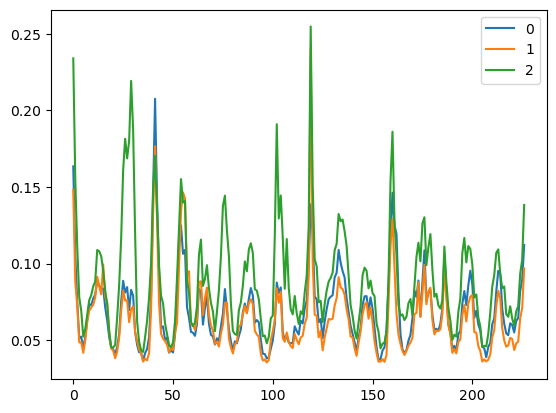

In [24]:
for i, var in enumerate([
    rmsf_10, 
    rmsf_0_10, 
    rmsf_0_80,
]):
#     plt.plot(var[:, 1] / var[:, 1].mean(), label=i)
    plt.plot(var[:, 1], label=i)
plt.legend()
plt.show()

In [25]:
rmsdev_10 = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/rmsdev_10ns.xvg'))
rmsdev_0_10 = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/rmsdev_0_10.xvg'))
rmsdev_0_80 = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/rmsdev_0_80.xvg'))

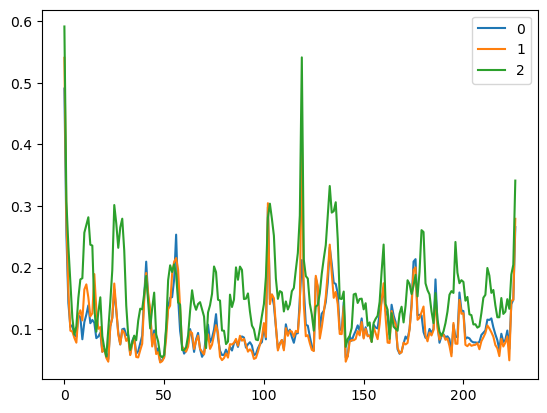

In [26]:
for i, var in enumerate([
    rmsdev_10, 
    rmsdev_0_10, 
    rmsdev_0_80,
]):
#     plt.plot(var[:, 1] / var[:, 1].mean(), label=i)
    plt.plot(var[:, 1], label=i)
plt.legend()
plt.show()

In [27]:
sasa = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/sasa.xvg'))[:, 2:]
sasa_10ns = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/sasa_10ns.xvg'))[:, 2:]
sasa_0_80 = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/sasa_0_80.xvg'))[:, 2:]

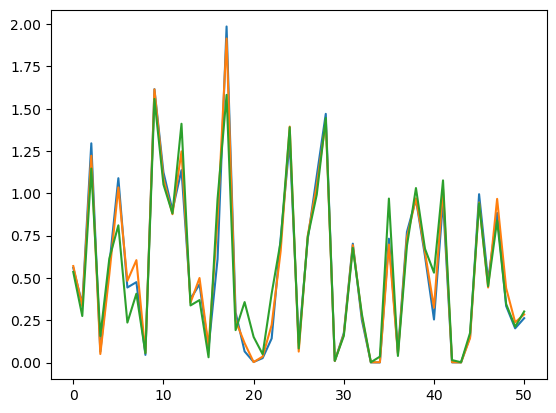

In [28]:
plt.plot(sasa.mean(axis=0))
plt.plot(sasa_10ns.mean(axis=0))
plt.plot(sasa_0_80.mean(axis=0))
plt.show()